In [18]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Link para solicitar token: https://www.banxico.org.mx/SieAPIRest/service/v1/token

In [3]:
token = '8ffecdc086d33fe006072c68d092316481e486cf476af47c8831437061f707c6'

In [4]:
def descargar_serie(serie, fechainicio, fechafin, token):
  url = 'http://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/'+fechainicio+'/'+fechafin
  print(url)
  headers = {'Bmx-Token':token}
  response = requests.get(url, headers=headers)
  status = response.status_code
  if status != 200:
    return print('Error en la consulta, codigo {}'.format(status))
  raw_data = response.json()
  data = raw_data['bmx']['series'][0]['datos']
  df = pd.DataFrame(data)
  df['dato'] = df['dato'].astype('float')
  df['fecha'] = pd.to_datetime(df['fecha'], format = '%d/%m/%Y')
  df.set_index('fecha', inplace=True)
  return df


## Titulo: Tipo de cambio pesos por dólar E.U.A

* Serie: SF60653
* Periocidad: Diaria
* Rango de fechas para consulta: '1995-04-04 - 2024-12-10'

In [5]:
CAMBIO_PESO_DOLAR_DIARIO = descargar_serie('SF60653','1995-04-04', '2024-12-10', token)

http://www.banxico.org.mx/SieAPIRest/service/v1/series/SF60653/datos/1995-04-04/2024-12-10


In [52]:
CAMBIO_PESO_DOLAR_DIARIO

,dato
fecha,
1995-04-04,6.8475
1995-04-05,6.8025
1995-04-06,6.5883
1995-04-07,6.4850
1995-04-08,6.3808
...,...
2024-12-06,20.2830
2024-12-07,20.1963
2024-12-08,20.1963


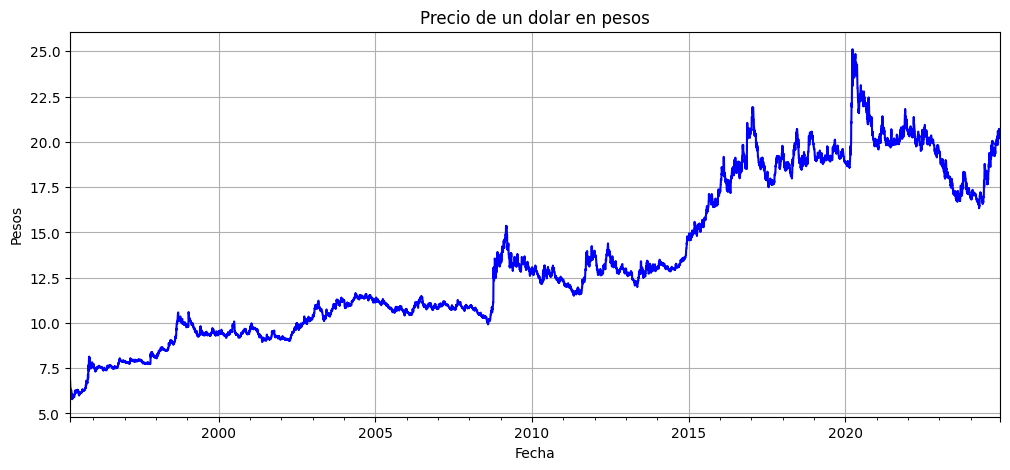

In [54]:
CAMBIO_PESO_DOLAR_DIARIO.plot(kind='line', 
                              figsize=(12,5),
                              title='Precio de un dolar en pesos',
                              grid=True,
                              color='blue',
                              legend=False)
# Personalizar el eje X
plt.xlabel('Fecha')  # Etiqueta para el eje X
plt.ylabel('Pesos')  # Etiqueta para el eje Y
plt.show()

## Titulo: Valor de UDIS

* Serie: SP68257
* Periocidad: Diaria
* Rango de fechas para consulta: '1995-04-04 - 2024-12-10'

In [7]:
UDIS_DIARIO = descargar_serie('SP68257','1995-04-04', '2024-12-10', token)

http://www.banxico.org.mx/SieAPIRest/service/v1/series/SP68257/datos/1995-04-04/2024-12-10


In [53]:
UDIS_DIARIO

,dato
fecha,
1995-04-04,1.000000
1995-04-05,1.001918
1995-04-06,1.003840
1995-04-07,1.005766
1995-04-08,1.007695
...,...
2024-12-06,8.329917
2024-12-07,8.331952
2024-12-08,8.333988


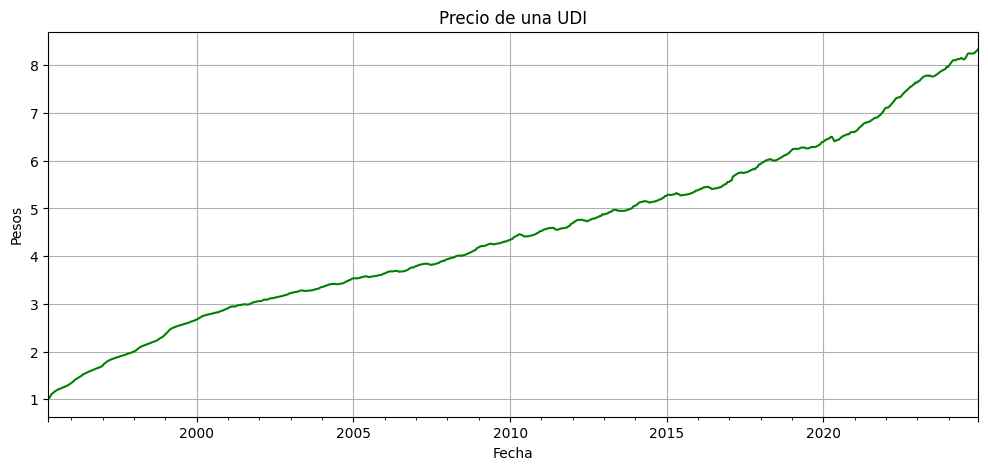

In [44]:
UDIS_DIARIO.plot(kind='line', 
                figsize=(12,5),
                title='Precio de una UDI',
                grid=True,
                color='green',
                legend=False)
plt.xlabel('Fecha') 
plt.ylabel('Pesos')
plt.show()

## Comparando Udis vs Dolares

Formula para calcular el rendimiento relativo de cada activo respecto a su valor inicial.

$$
\text{Rendimiento (\%)} = \left( \frac{\text{Valor actual} - \text{Valor inicial}}{\text{Valor inicial}} \right) \times 100
$$

Es útil para comparar rendimientos entre UDIs y dólares.

Al graficarlos, se podra ver cuál ha dado más rendimiento a lo largo del tiempo.

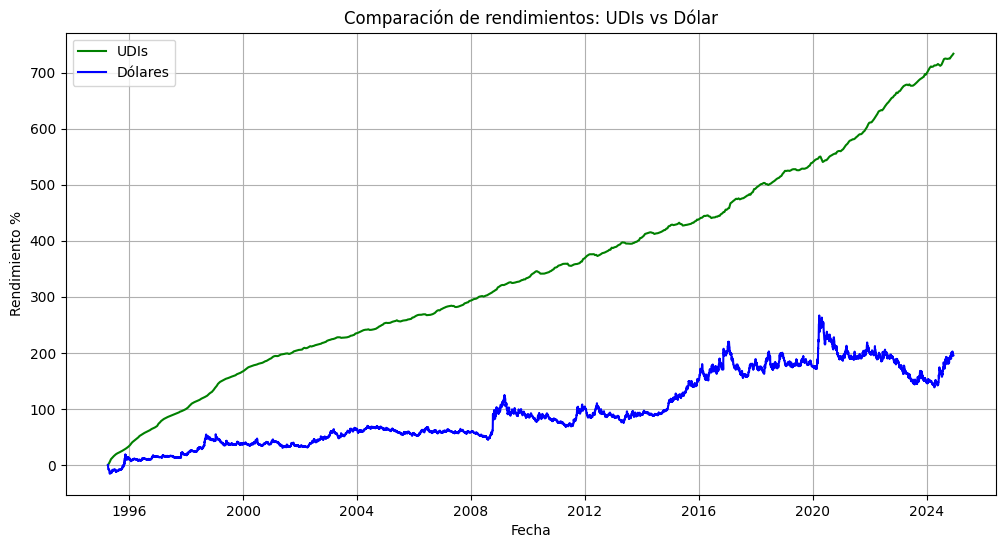

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos obtenidos de la BANXICO usando la API
fechas = UDIS_DIARIO.index.to_list()
udis = UDIS_DIARIO['dato'].to_list()
dolares = CAMBIO_PESO_DOLAR_DIARIO['dato'].to_list()

# Calculandio rendimiento
udis_normalizados = [((x / udis[0])-1)*100 for x in udis]
dolares_normalizados = [((x / dolares[0])-1)*100 for x in dolares]

# DataFrame
data = pd.DataFrame({
    'Fecha': fechas,
    'UDIs': udis_normalizados,
    'Dólares': dolares_normalizados
})

# Gráfica
plt.figure(figsize=(12, 6))
plt.plot(data['Fecha'], data['UDIs'], label='UDIs', color='green')#, marker='.')
plt.plot(data['Fecha'], data['Dólares'], label='Dólares', color='blue')#, marker='.')
plt.title('Comparación de rendimientos: UDIs vs Dólar')
plt.xlabel('Fecha')
plt.ylabel('Rendimiento %')
plt.legend()
plt.grid()
plt.savefig("grafico_ejemplo.png", dpi=300, bbox_inches='tight')
plt.show()


In [57]:
(( UDIS_DIARIO.loc['2024-12-10','dato'] - UDIS_DIARIO.loc['1995-04-04','dato'] )/UDIS_DIARIO.loc['1995-04-04','dato'])*100 

733.8061

In [59]:
(( CAMBIO_PESO_DOLAR_DIARIO.loc['2024-12-10','dato'] - CAMBIO_PESO_DOLAR_DIARIO.loc['1995-04-04','dato'] )/CAMBIO_PESO_DOLAR_DIARIO.loc['1995-04-04','dato'])*100 # '1995-04-04', '2024-12-10'

195.39978094194961

In [29]:
UDIS_DIARIO.loc['2012-01-01','dato']

4.692796

In [30]:
CAMBIO_PESO_DOLAR_DIARIO.loc['2000-01-01','dato'] 

9.5222

In [31]:
CAMBIO_PESO_DOLAR_DIARIO.loc['2012-01-01','dato'] 

13.9787

In [32]:
max(udis)

8.338061

In [33]:
min(udis)

1.0

In [34]:
CAMBIO_PESO_DOLAR_DIARIO['dato'].tail()

fecha
2024-12-06    20.2830
2024-12-07    20.1963
2024-12-08    20.1963
2024-12-09    20.1963
2024-12-10    20.2275
Name: dato, dtype: float64

In [35]:
CAMBIO_PESO_DOLAR_DIARIO['dato'].head()

fecha
1995-04-04    6.8475
1995-04-05    6.8025
1995-04-06    6.5883
1995-04-07    6.4850
1995-04-08    6.3808
Name: dato, dtype: float64

data

In [51]:
CAMBIO_PESO_DOLAR_DIARIO

,dato
fecha,
1995-04-04,6.8475
1995-04-05,6.8025
1995-04-06,6.5883
1995-04-07,6.4850
1995-04-08,6.3808
...,...
2024-12-06,20.2830
2024-12-07,20.1963
2024-12-08,20.1963


En mi tiempo libre me gusta explorar datos y recientemente estaba explorando la API de Banxico, y realice un pequeño análisis en Python para comparar el rendimiento de dos opciones donde popularmente se invierte en México: el dólar y las UDIs. 

Calculé el rendiento de cada activo entre las fechas 1995-04-04 y 2024-12-10, y hasta el dia de hoy las udis han dado un 733% mientras que los dólares 195%

Tu publicación tiene una buena base, pero con algunos ajustes puedes hacerla más atractiva y profesional en LinkedIn. Aquí está una versión mejorada:

---

### **Propuesta de Publicación:**

📊 **¿Dónde conviene más invertir: en dólares o en UDIs?** 💵 vs. 💹  

En mis tiempos libres, me gusta explorar datos y aprender nuevas herramientas. Recientemente, trabajé con la **API de Banxico** y **Python** para analizar el rendimiento de dos opciones de inversión populares en México: el **dólar** y las **UDIs**.  

🔍 **¿Qué descubrí?**  
Comparé los rendimientos de ambos activos desde el **4 de abril de 1995** hasta el **10 de diciembre de 2024**. Los resultados son reveladores:  
- **UDIs**: Un crecimiento acumulado del **733%**.  
- **Dólar**: Un crecimiento acumulado del **195%**.  

Este análisis demuestra que las **UDIs** han ofrecido un mayor rendimiento a largo plazo, además de ser una opción más estable y ajustada a la inflación.  

🔧 **¿Cómo lo hice?**  
- Utilicé la **API de Banxico** para obtener datos históricos.  
- Analicé y procesé la información con **Python** y **Pandas**.  
- Calcule los rendimientos con fórmulas de variación porcentual y graficando las tendencias para visualizar mejor los resultados.  

💡 **Mi motivación:**  
Me apasiona el análisis de datos y, a través de proyectos como este, busco aprender y compartir conocimientos. Si te interesa esta área o trabajas en temas relacionados con **data science**, ¡me encantaría conectar contigo! 😊  

---

¿Qué opinas de los resultados? ¿Tú en qué invertirías?  

---

### **Razones para este enfoque:**
1. **Introducción atractiva:** La pregunta inicial genera curiosidad.  
2. **Resultados claros:** Mencionas las fechas específicas y los porcentajes exactos.  
3. **Herramientas utilizadas:** Destacas tus habilidades técnicas con Python y la API de Banxico.  
4. **Motivación personal:** Refuerzas que este es un proyecto en tu tiempo libre, mostrando tu interés genuino en análisis de datos.  
5. **Call to Action:** Invitas a que otros interactúen contigo y generas networking.  

Si te parece bien, puedo ayudarte a ajustarlo más o incluir gráficos para complementar tu publicación. ¿Qué opinas? 🚀